<a href="https://colab.research.google.com/github/trangavo/Urea-Cycle/blob/main/FINAL_UREA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References:

- 2. Constructing Models—MASSpy 0.1.1 documentation. (n.d.). Retrieved April 11, 2021, from https://masspy.readthedocs.io/en/stable/tutorials/constructing_models.html

- 10. Glycolysis—MASSpy 0.1.1 documentation. (n.d.). Retrieved April 11, 2021, from https://masspy.readthedocs.io/en/stable/education/sb2/chapters/sb2_chapter10.html#Defining-the-Steady-State

- MetaCyc urea cycle. (n.d.). Retrieved April 11, 2021, from https://metacyc.org/META/NEW-IMAGE?type=PATHWAY&object=PWY-4984&detail-level=4

- Phosphofructokinase (PFK) Model Construction—MASSpy 0.1.1 documentation. (n.d.). Retrieved April 27, 2021, from https://masspy.readthedocs.io/en/stable/education/sb2/model_construction/sb2_pfk.html

# Import packages

In [75]:
!pip install masspy

In [76]:
import numpy as np
import pandas as pd
from scipy import optimize

from cobra import DictList

from mass import (
    MassConfiguration, MassMetabolite, MassModel, MassReaction, MassModel,
    Simulation, MassSolution, strip_time, Unit, UnitDefinition, qcqa_model)

from mass.util.matrix import left_nullspace, nullspace, matrix_rank
from mass.util.expressions import Keq2k, k2Keq, strip_time
from mass.util.qcqa import qcqa_model
from mass.enzyme_modules import EnzymeModule

from mass.core.units import print_defined_unit_values

from operator import attrgetter
from os import path
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sym

from mass.io import json, sbml
from mass.visualization import (
    plot_time_profile, plot_phase_portrait, plot_tiled_phase_portraits)

In [77]:
# Configuration setup
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")

In [78]:
# Visualization setup
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.3f}'.format
S_FONT = {"size": "small"}
L_FONT = {"size": "large"}
INF = float("inf")

# Build the model

## Create the model

In [79]:
model = MassModel("Urea_Cycle")

## Create metabolites

In [80]:
"""
Each metabolite in the network is created with
an ID, a name, its formula, its charge, and the compartment it is in (mitochrondia, cytosol or both).
"""

hco3_m = MassMetabolite(
    "hco3_m",
    name="Carbonic acid",
    formula="HCO3",
    charge=-1,
    compartment="m")

nh4_m = MassMetabolite(
    "nh4_m",
    name="Ammonium",
    formula="NH4",
    charge=1,
    compartment="m")

h = MassMetabolite(
    "h",
    name="Hydrogen",
    formula="H",
    charge=1,
    compartment="both")

atp = MassMetabolite(
    "atp",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="both")

adp_m = MassMetabolite(
    "adp_m",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="m")

pi_m = MassMetabolite(
    "pi_m",
    name="Phosphate",
    formula="PO4",
    charge=-3,
    compartment="m")

carb_phos_m = MassMetabolite(
    "carb_phos_m",
    name="Carbamoyl phosphate",
    formula="NH2CO2PO3",
    charge=-2,
    compartment="m")

ornithine = MassMetabolite(
    "ornithine",
    name="Ornithine",
    formula="C5H13N2O2",
    charge=1,
    compartment="both")

citrulline = MassMetabolite(
    "citrulline",
    name="Citrulline",
    formula="C6H13N3O3",
    charge=0,
    compartment="both")

ppi_c = MassMetabolite(
    "ppi_c",
    name="Diphosphate",
    formula="P2O7",
    charge=-4,
    compartment="c")

amp_c = MassMetabolite(
    "amp_c",
    name="AMP",
    formula="C10H12N5O7P",
    charge=-2,
    compartment="c")

aspartate_c = MassMetabolite(
    "aspartate_c",
    name="Aspartate",
    formula="C4H6NO4",
    charge=-1,
    compartment="c")

argi_suc_c = MassMetabolite(
    "argi_suc_c",
    name="Argigino succinate",
    formula="C10H17N4O6",
    charge=-1,
    compartment="c")

fumarate_c = MassMetabolite(
    "fumarate_c",
    name="Fumarate",
    formula="C4H2O4",
    charge=-2,
    compartment="c")

arginine_c = MassMetabolite(
    "arginine_c",
    name="Arginine",
    formula="C6H15N4O2",
    charge=1,
    compartment="c")

h2o_c = MassMetabolite(
    "h2o_c",
    name="Water",
    formula="H2O",
    charge=0,
    compartment="c")

urea_c = MassMetabolite(
    "urea_c",
    name="Urea",
    formula="CH4N2O",
    charge=0,
    compartment="c")

## Create reactions

### Main reactions

In [81]:
# Define main reactions in the network

enter = MassReaction("CPS", name="Entering", reversible=False)
condense_1 = MassReaction("OTC", name="Condensation 1", reversible=False)
condense_2 = MassReaction("ASD", name="Condensation 2", reversible=False)
cleave_1 = MassReaction("ALD", name="Cleavage 1", reversible=False)
cleave_2 = MassReaction("AG", name="Cleavage 2", reversible=False)

# Add metabolites
# the value of each metabolite shows whether it is a reactant (negative) or a product (positive),
# and its coefficient

enter.add_metabolites({
    nh4_m: -1,
    hco3_m: -1,
    atp: -2,
    h: 3,
    pi_m: 1,
    adp_m: 2,
    carb_phos_m: 1
})

condense_1.add_metabolites({
    carb_phos_m: -1,
    ornithine: -1,
    pi_m: 1,
    h: 2,
    citrulline: 1
})

condense_2.add_metabolites({
    citrulline: -1,
    aspartate_c: -1,
    atp: -1,
    h: 2,
    ppi_c: 1,
    amp_c: 1,
    argi_suc_c: 1
})

cleave_1.add_metabolites({
    argi_suc_c: -1,
    fumarate_c: 1,
    arginine_c: 1
})

cleave_2.add_metabolites({
    arginine_c: -1,
    h2o_c: -1,
    ornithine: 1,
    urea_c: 1
})

# Add the reactions to the model
model.add_reactions([enter, condense_1, condense_2, cleave_1, cleave_2])

### Boundary reactions

In [82]:
# Define and add boundary reactions

# for example, there is a source for hco3
hco3_in = model.add_boundary(
    model.metabolites.hco3_m,
    boundary_type="demand",
    reaction_id="hco3_in")
# by default, it is consumed, so we have to reverse it
hco3_in.reverse_stoichiometry(inplace=True)

nh4_in = model.add_boundary(
    model.metabolites.nh4_m,
    boundary_type="demand",
    reaction_id="nh4_in")
nh4_in.reverse_stoichiometry(inplace=True)

atp_in = model.add_boundary(
    model.metabolites.atp,
    boundary_type="demand",
    reaction_id="atp_in")
atp_in.reverse_stoichiometry(inplace=True)

aspartate_in = model.add_boundary(
    model.metabolites.aspartate_c,
    boundary_type="demand",
    reaction_id="aspartate_in")
aspartate_in.reverse_stoichiometry(inplace=True)

h2o_in = model.add_boundary(
    model.metabolites.h2o_c,
    boundary_type="demand",
    reaction_id="h2o_in")
h2o_in.reverse_stoichiometry(inplace=True)

h_out = model.add_boundary(
    model.metabolites.h,
    boundary_type="demand",
    reaction_id="h_out")

adp_out = model.add_boundary(
    model.metabolites.adp_m,
    boundary_type="demand",
    reaction_id="adp_out")

pi_out = model.add_boundary(
    model.metabolites.pi_m,
    boundary_type="demand",
    reaction_id="pi_out")

amp_out = model.add_boundary(
    model.metabolites.amp_c,
    boundary_type="demand",
    reaction_id="amp_out")

ppi_out = model.add_boundary(
    model.metabolites.ppi_c,
    boundary_type="demand",
    reaction_id="ppi_out")

fumarate_out = model.add_boundary(
    model.metabolites.fumarate_c,
    boundary_type="demand",
    reaction_id="fumarate_out")

urea_out = model.add_boundary(
    model.metabolites.urea_c,
    boundary_type="demand",
    reaction_id="urea_out")

In [83]:
# Check the number of reactions and metabolites
print(f"Number of metabolites: {len(model.metabolites)}")
print(f"Number of all reactions: {len(model.reactions)}")
print(f"Number of boundary reactions: {len(model.boundary)}")

Number of metabolites: 17
Number of all reactions: 17
Number of boundary reactions: 12


In [84]:
# Check all the boundary reactions
print('All the boundary reactions')
for boundary in model.boundary:
    print(boundary)
    
# Check all the reactions
print('All the main reactions')
for reaction in model.reactions[:5]:
    print(reaction)

All the boundary reactions
hco3_in:  --> hco3_m
nh4_in:  --> nh4_m
atp_in:  --> atp
aspartate_in:  --> aspartate_c
h2o_in:  --> h2o_c
h_out: h --> 
adp_out: adp_m --> 
pi_out: pi_m --> 
amp_out: amp_c --> 
ppi_out: ppi_c --> 
fumarate_out: fumarate_c --> 
urea_out: urea_c --> 
All the main reactions
CPS: 2 atp + hco3_m + nh4_m --> 2 adp_m + carb_phos_m + 3 h + pi_m
OTC: carb_phos_m + ornithine --> citrulline + 2 h + pi_m
ASD: aspartate_c + atp + citrulline --> amp_c + argi_suc_c + 2 h + ppi_c
ALD: argi_suc_c --> arginine_c + fumarate_c
AG: arginine_c + h2o_c --> ornithine + urea_c


# Add values of metabolites and reactions

In [85]:
np.random.seed(123)

## Initial concentrations

In [86]:
# Add the initial concentrations of all metabolites

for metabolite in model.metabolites:
    metabolite.ic = np.random.uniform(0, 10)
    
h2o_c.ic = 55000
hco3_m.ic = 24.5
nh4_m.ic = 0.0385
h.ic = 10
atp.ic = 1.077
adp_m.ic = 0.16
pi_m.ic = 1.137
carb_phos_m.ic = 0.029
ornithine.ic = 0.013
citrulline.ic =  0.02875
ppi_c.ic = 0.0018
amp_c.ic = 0.019
aspartate_c.ic = 0.0155
argi_suc_c.ic = 0.00175
fumarate_c.ic = 0.000945
arginine_c.ic = 0.07683
urea_c.ic = 1.682

# Show all the metabolites and their initial concentrations
metabolite_ids = [m.id for m in model.metabolites]
table_1 = pd.DataFrame(
    np.array([metabolite_ids,
              [met.name for met in model.metabolites],
              [model.initial_conditions[met]
               for met in model.metabolites]]).T,
    index=[i for i in range(1, len(metabolite_ids) + 1)],
    columns=["Abbreviations", "Species", "Initial Concentration"])
table_1

,Abbreviations,Species,Initial Concentration
1,nh4_m,Ammonium,0.0385
2,hco3_m,Carbonic acid,24.5
3,atp,ATP,1.077
4,h,Hydrogen,10
5,pi_m,Phosphate,1.137
6,adp_m,ADP,0.16
7,carb_phos_m,Carbamoyl phosphate,0.029
8,ornithine,Ornithine,0.013
9,citrulline,Citrulline,0.02875
10,aspartate_c,Aspartate,0.0155


## Reaction rates

In [87]:

# hco3_in.kf = 2.6
# nh4_in.kf = 6
# atp_in.kf = 1.2
# aspartate_in.kf = 3.5
# h2o_in.kf = 3.2
# h_out.kf = 4.3
# adp_out.kf = 5.2
# pi_out.kf = 3.1
# amp_out.kf = 2.7
# ppi_out.kf = 4.1
# fumarate_out.kf = 1.2
# urea_out.kf = 2.8

for reaction in model.reactions:
    reaction.kf = np.random.uniform(200, 2000)

enter.forward_rate_constant = 1.213*1000
condense_1.kf = 2.3*1000
condense_2.kf = 0.1295*1000
cleave_1.kf = 10.3*1000
cleave_2.kf = 0.034*1000

for reaction in model.reactions:
    print(reaction.parameters)

{'kf_CPS': 1213.0, 'Keq_CPS': inf}
{'kf_OTC': 2300.0, 'Keq_OTC': inf}
{'kf_ASD': 129.5, 'Keq_ASD': inf}
{'kf_ALD': 10300.0, 'Keq_ALD': inf}
{'kf_AG': 34.0, 'Keq_AG': inf}
{'kf_hco3_in': 1504.0195847491434, 'Keq_hco3_in': inf}
{'kf_nh4_in': 1299.8423192196492, 'Keq_nh4_in': inf}
{'kf_atp_in': 1500.3980886263987, 'Keq_atp_in': inf}
{'kf_aspartate_in': 781.3260449357208, 'Keq_aspartate_in': inf}
{'kf_h2o_in': 851.2195801201653, 'Keq_h2o_in': inf}
{'kf_h_out': 610.8738155821202, 'Keq_h_out': inf}
{'kf_adp_out': 728.6852834998929, 'Keq_adp_out': inf}
{'kf_pi_out': 1335.7570229380779, 'Keq_pi_out': inf}
{'kf_amp_out': 365.78889190113534, 'Keq_amp_out': inf}
{'kf_ppi_out': 980.6621108231508, 'Keq_ppi_out': inf}
{'kf_fumarate_out': 975.5529739933588, 'Keq_fumarate_out': inf}
{'kf_urea_out': 1088.6331757705511, 'Keq_urea_out': inf}


# Stoichiometric matrix

## Inspect stoichiometric matrix

In [88]:
# Show the stoichiometric matrix
model.update_S(array_type="DataFrame", dtype=np.int_, update_model=True)
table_2 = model.S
table_2

,CPS,OTC,ASD,ALD,AG,hco3_in,nh4_in,atp_in,aspartate_in,h2o_in,h_out,adp_out,pi_out,amp_out,ppi_out,fumarate_out,urea_out
nh4_m,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
hco3_m,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
atp,-2,0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
h,3,2,2,0,0,0,0,0,0,0,-1,0,0,0,0,0,0
pi_m,1,1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0
adp_m,2,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0
carb_phos_m,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ornithine,0,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
citrulline,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aspartate_c,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [89]:
print('Dimensions of matrix: ', model.S.shape)
print('Rank of matrix: ', matrix_rank(model.S))

Dimensions of matrix:  (17, 17)
Rank of matrix:  16


## Check if the model is balanced

In [90]:
# Show the elemental matrix
table_3 = model.get_elemental_matrix(
    array_type="DataFrame", dtype=np.int64)
table_3

,nh4_m,hco3_m,atp,h,pi_m,adp_m,carb_phos_m,ornithine,citrulline,aspartate_c,ppi_c,amp_c,argi_suc_c,fumarate_c,arginine_c,h2o_c,urea_c
C,0,1,10,0,0,10,1,5,6,4,0,10,10,4,6,0,1
H,4,1,12,1,0,12,2,13,13,6,0,12,17,2,15,2,4
O,0,3,13,0,4,10,5,2,3,4,7,7,6,4,2,1,1
P,0,0,3,0,1,2,1,0,0,0,2,1,0,0,0,0,0
N,1,0,5,0,0,5,1,2,3,1,0,5,4,0,4,0,2
S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
q,1,-1,-4,1,-3,-3,-2,1,0,-1,-4,-2,-1,-2,1,0,0


In [91]:
# Check if the model is elementally and charge balanced
table_4 = model.get_elemental_charge_balancing(
    array_type="DataFrame", dtype=np.int64)
table_4

,CPS,OTC,ASD,ALD,AG,hco3_in,nh4_in,atp_in,aspartate_in,h2o_in,h_out,adp_out,pi_out,amp_out,ppi_out,fumarate_out,urea_out
C,0,0,0,0,0,1,0,10,4,0,0,-10,0,-10,0,-4,-1
H,0,0,0,0,0,1,4,12,6,2,-1,-12,0,-12,0,-2,-4
O,0,0,0,0,0,3,0,13,4,1,0,-10,-4,-7,-7,-4,-1
P,0,0,0,0,0,0,0,3,0,0,0,-2,-1,-1,-2,0,0
N,0,0,0,0,0,0,1,5,1,0,0,-5,0,-5,0,0,-2
S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
q,0,0,0,0,0,-1,1,-4,-1,0,-1,3,3,2,4,2,0


## Inspect the nullspace

In [92]:
# Get the null space
ns = nullspace(model.S)

# Divide by the minimum and round to nearest integer
ns = np.rint(ns / np.min(ns[np.nonzero(ns)]))

# Show the nullspace
table_5 = pd.DataFrame(
    ns, index=model.reactions.list_attr("id"),
    columns=["Pathway 1"], dtype=np.int_).T
table_5

,CPS,OTC,ASD,ALD,AG,hco3_in,nh4_in,atp_in,aspartate_in,h2o_in,h_out,adp_out,pi_out,amp_out,ppi_out,fumarate_out,urea_out
Pathway 1,1,1,1,1,1,1,1,3,1,1,7,2,2,1,1,1,1


In [93]:
# Check if the found pathway is balanced
table_6 = model.get_elemental_charge_balancing(
    array_type="DataFrame").dot(ns).astype(np.int64)
table_6.columns = ['Pathway 1']
table_6

,Pathway 1
C,0
H,0
O,0
P,0
N,0
S,0
q,0


## Inspect the left nullspace

In [94]:
# Get the left nullspace
lns = left_nullspace(model.S, rtol=1e-10)

# Iterate through left nullspace, dividing by the smallest value in each row.
for i, row in enumerate(lns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in new_row])

# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(lns):
    lns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Show the left nullspace
lns = lns.astype(np.int64)
table_7 = pd.DataFrame(lns, columns=metabolite_ids)
table_7

,nh4_m,hco3_m,atp,h,pi_m,adp_m,carb_phos_m,ornithine,citrulline,aspartate_c,ppi_c,amp_c,argi_suc_c,fumarate_c,arginine_c,h2o_c,urea_c
0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0


# Add compartments and units

## Add compartments

In [95]:
model.compartments = {"c": "cytosol", "m": "mitochondria", "both": "both"}
model.compartments

{'both': 'both', 'c': 'cytosol', 'm': 'mitochondria'}

## Add units

In [96]:
# Check the default units
print_defined_unit_values("BaseUnitKinds")

╒═════════════════════════════╕
│ SBML Base Unit Kinds        │
╞═════════════════════════════╡
│ Base Unit        SBML Value │
│ -------------  ------------ │
│ ampere                    0 │
│ avogadro                  1 │
│ becquerel                 2 │
│ candela                   3 │
│ coulomb                   5 │
│ dimensionless             6 │
│ farad                     7 │
│ gram                      8 │
│ gray                      9 │
│ henry                    10 │
│ hertz                    11 │
│ item                     12 │
│ joule                    13 │
│ katal                    14 │
│ kelvin                   15 │
│ kilogram                 16 │
│ liter                    17 │
│ litre                    18 │
│ lumen                    19 │
│ lux                      20 │
│ meter                    21 │
│ metre                    22 │
│ mole                     23 │
│ newton                   24 │
│ ohm                      25 │
│ pascal                   26 │
│ radian

In [97]:
# Create concentration unit
millimole = Unit(kind="mole", exponent=1, scale=-3, multiplier=1)
per_liter = Unit(kind="liter", exponent=-1, scale=1, multiplier=1)

concentration_unit = UnitDefinition(id="mM", name="Millimolar",
                                    list_of_units=[millimole, per_liter])
print('Concentration unit')
print("{0}:\n{1!r}\n{2!r}".format(
    concentration_unit.name, *concentration_unit.list_of_units))

# Create time unit
time_unit = UnitDefinition(id="min", name="Minute")
time_unit.create_unit(kind="second", exponent=1, scale=1, multiplier=60)
print('Time unit')
print(time_unit)
print(time_unit.list_of_units)

# Add units to the model
model.add_units([concentration_unit, time_unit])
model.units

Concentration unit
Millimolar:
<Unit at 0x7f01765de190 kind: liter; exponent: -1; scale: 1; multiplier: 1>
<Unit at 0x7f01765de850 kind: mole; exponent: 1; scale: -3; multiplier: 1>
Time unit
min
[<Unit at 0x7f01762a28d0 kind: second; exponent: 1; scale: 1; multiplier: 60>]


[<UnitDefinition Millimolar "mM" at 0x7f01765dec50>,
 <UnitDefinition Minute "min" at 0x7f01733a6710>]

# Ensure model completeness

## Check the model

In [98]:
model

Name,Urea_Cycle
Memory address,0x07f01765facd0
Stoichiometric Matrix,17x17
Matrix Rank,16
Number of metabolites,17
Initial conditions defined,17/17
Number of reactions,17
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


## Check the expressions for reaction rates

In [99]:
# Check the rates of reactions
for reaction, rate in model.rates.items():
    print(f"{reaction.id}: {rate}")

CPS: kf_CPS*atp(t)**2*hco3_m(t)*nh4_m(t)
OTC: kf_OTC*carb_phos_m(t)*ornithine(t)
ASD: kf_ASD*aspartate_c(t)*atp(t)*citrulline(t)
ALD: kf_ALD*argi_suc_c(t)
AG: kf_AG*arginine_c(t)
hco3_in: hco3_b*kf_hco3_in
nh4_in: kf_nh4_in*nh4_b
atp_in: atp_b*kf_atp_in
aspartate_in: aspartate_b*kf_aspartate_in
h2o_in: h2o_b*kf_h2o_in
h_out: kf_h_out*h(t)
adp_out: kf_adp_out*adp_m(t)
pi_out: kf_pi_out*pi_m(t)
amp_out: kf_amp_out*amp_c(t)
ppi_out: kf_ppi_out*ppi_c(t)
fumarate_out: kf_fumarate_out*fumarate_c(t)
urea_out: kf_urea_out*urea_c(t)


## Check metabolites ODEs

In [100]:
# Check the ODE of each metabolite
for metabolite, ode in model.odes.items():
    print(f"{metabolite.id}: {ode}")

nh4_m: -kf_CPS*atp(t)**2*hco3_m(t)*nh4_m(t) + kf_nh4_in*nh4_b
hco3_m: hco3_b*kf_hco3_in - kf_CPS*atp(t)**2*hco3_m(t)*nh4_m(t)
atp: atp_b*kf_atp_in - kf_ASD*aspartate_c(t)*atp(t)*citrulline(t) - 2*kf_CPS*atp(t)**2*hco3_m(t)*nh4_m(t)
h: 2*kf_ASD*aspartate_c(t)*atp(t)*citrulline(t) + 3*kf_CPS*atp(t)**2*hco3_m(t)*nh4_m(t) + 2*kf_OTC*carb_phos_m(t)*ornithine(t) - kf_h_out*h(t)
pi_m: kf_CPS*atp(t)**2*hco3_m(t)*nh4_m(t) + kf_OTC*carb_phos_m(t)*ornithine(t) - kf_pi_out*pi_m(t)
adp_m: 2*kf_CPS*atp(t)**2*hco3_m(t)*nh4_m(t) - kf_adp_out*adp_m(t)
carb_phos_m: kf_CPS*atp(t)**2*hco3_m(t)*nh4_m(t) - kf_OTC*carb_phos_m(t)*ornithine(t)
ornithine: kf_AG*arginine_c(t) - kf_OTC*carb_phos_m(t)*ornithine(t)
citrulline: -kf_ASD*aspartate_c(t)*atp(t)*citrulline(t) + kf_OTC*carb_phos_m(t)*ornithine(t)
aspartate_c: aspartate_b*kf_aspartate_in - kf_ASD*aspartate_c(t)*atp(t)*citrulline(t)
ppi_c: kf_ASD*aspartate_c(t)*atp(t)*citrulline(t) - kf_ppi_out*ppi_c(t)
amp_c: kf_ASD*aspartate_c(t)*atp(t)*citrulline(t) - kf

## Check model completeness

In [101]:
qcqa_model(model, parameters=True, concentrations=True)

╒══════════════════════════════════════════╕
│ MODEL ID: Urea_Cycle                     │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


In [102]:
# model_og = model

In [103]:
# model = model_og

# Compute steady state

## Steady state fluxes

In [104]:
# Set independent fluxes to determine steady state flux vector
independent_fluxes = {
    model.reactions.nh4_in: 2.1}

# Compute steady state fluxes
ssfluxes = model.compute_steady_state_fluxes(
    ns.T,
    independent_fluxes,
    update_reactions=True)

# Show the steady ste fluxes
reaction_ids = [r.id for r in model.reactions]
table_8 = pd.DataFrame(list(ssfluxes.values()), index=reaction_ids,
                          columns=["v_stst"]).T
table_8

,CPS,OTC,ASD,ALD,AG,hco3_in,nh4_in,atp_in,aspartate_in,h2o_in,h_out,adp_out,pi_out,amp_out,ppi_out,fumarate_out,urea_out
v_stst,2.100,2.100,2.100,2.100,2.100,2.100,2.100,6.300,2.100,2.100,14.700,4.200,4.200,2.100,2.100,2.100,2.100


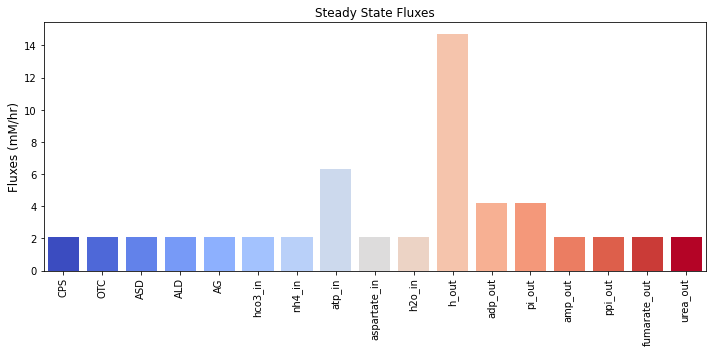

In [105]:
# Visualize steady state fluxes

# Set up the figure
fig_1, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# Define indicies for bar chart
indicies = np.arange(len(reaction_ids))+0.5
# Define colors to use
c = plt.cm.coolwarm(np.linspace(0, 1, len(reaction_ids)))
# Plot bar chart
ax.bar(indicies, ssfluxes.values(), width=0.8, color=c);
ax.set_xlim([0, len(reaction_ids)])
# Set labels and adjust ticks
ax.set_xticks(indicies)
ax.set_xticklabels(reaction_ids, rotation="vertical")
ax.set_ylabel("Fluxes (mM/hr)", L_FONT)
ax.set_title("Steady State Fluxes", L_FONT)
fig_1.tight_layout()

In [106]:
# Check if this is really the steady state flux
pd.DataFrame(
    model.S.dot(np.array(list(ssfluxes.values()))),
    index=metabolite_ids,
    columns=["S x v_stst"],
    dtype=np.int64).T

,nh4_m,hco3_m,atp,h,pi_m,adp_m,carb_phos_m,ornithine,citrulline,aspartate_c,ppi_c,amp_c,argi_suc_c,fumarate_c,arginine_c,h2o_c,urea_c
S x v_stst,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Compute PERCs

In [107]:
percs = model.calculate_PERCs(update_reactions=True)
percs

{'kf_AG': 27.33307301835221,
 'kf_ALD': 1200.0,
 'kf_ASD': 4375.564037551716,
 'kf_CPS': 1.9193804823294707,
 'kf_OTC': 5570.291777188329,
 'kf_adp_out': 26.25,
 'kf_amp_out': 110.52631578947368,
 'kf_aspartate_in': 100000.0,
 'kf_atp_in': 100000.0,
 'kf_fumarate_out': 2222.222222222222,
 'kf_h2o_in': 100000.0,
 'kf_h_out': 1.4700000000000002,
 'kf_hco3_in': 100000.0,
 'kf_nh4_in': 100000.0,
 'kf_pi_out': 3.6939313984168867,
 'kf_ppi_out': 1166.6666666666667,
 'kf_urea_out': 1.2485136741973841}

In [108]:
for r in model.reactions:
    print(r.parameters)

{'kf_CPS': 1.9193804823294707, 'Keq_CPS': inf}
{'kf_OTC': 5570.291777188329, 'Keq_OTC': inf}
{'kf_ASD': 4375.564037551716, 'Keq_ASD': inf}
{'kf_ALD': 1200.0, 'Keq_ALD': inf}
{'kf_AG': 27.33307301835221, 'Keq_AG': inf}
{'kf_hco3_in': 100000.0, 'Keq_hco3_in': inf}
{'kf_nh4_in': 100000.0, 'Keq_nh4_in': inf}
{'kf_atp_in': 100000.0, 'Keq_atp_in': inf}
{'kf_aspartate_in': 100000.0, 'Keq_aspartate_in': inf}
{'kf_h2o_in': 100000.0, 'Keq_h2o_in': inf}
{'kf_h_out': 1.4700000000000002, 'Keq_h_out': inf}
{'kf_adp_out': 26.25, 'Keq_adp_out': inf}
{'kf_pi_out': 3.6939313984168867, 'Keq_pi_out': inf}
{'kf_amp_out': 110.52631578947368, 'Keq_amp_out': inf}
{'kf_ppi_out': 1166.6666666666667, 'Keq_ppi_out': inf}
{'kf_fumarate_out': 2222.222222222222, 'Keq_fumarate_out': inf}
{'kf_urea_out': 1.2485136741973841, 'Keq_urea_out': inf}


# Simulation and results

In [109]:
sim0 = Simulation(reference_model=model)
sim0.steady_state_solver.maximum_iterations = 5000
conc_sol, flux_sol = sim0.find_steady_state(model, strategy="simulate",
                                           update_values=True, verbose=True)
model.initial_conditions  # Same object as reference model in Simulation

Setting output selections
Setting simulation values for 'Urea_Cycle'
Setting output selections
Getting time points
Simulating 'Urea_Cycle'
Found steady state for 'Urea_Cycle'.
Updating 'Urea_Cycle' values
Adding 'Urea_Cycle' simulation solutions to output


{<MassMetabolite adp_m at 0x7f01765ef510>: 2.5970328464212366e-46,
 <MassMetabolite amp_c at 0x7f01764c2490>: 2.521284008737853e-117,
 <MassMetabolite argi_suc_c at 0x7f017335a650>: 0.00175,
 <MassMetabolite arginine_c at 0x7f017335a550>: 0.07683,
 <MassMetabolite aspartate_c at 0x7f017335ad90>: 7.396869150837639e-132,
 <MassMetabolite atp at 0x7f0176451650>: 0.9845000000000009,
 <MassMetabolite carb_phos_m at 0x7f01765ef410>: 0.029,
 <MassMetabolite citrulline at 0x7f01764c2090>: 0.08075000000000006,
 <MassMetabolite fumarate_c at 0x7f017335a090>: 0.000945,
 <MassMetabolite h at 0x7f01764514d0>: 7.484530419439464e-37,
 <MassMetabolite h2o_c at 0x7f017335a510>: 54999.90591999999,
 <MassMetabolite hco3_m at 0x7f01734910d0>: 24.461500000000015,
 <MassMetabolite nh4_m at 0x7f0176451490>: 1.1848562607754664e-46,
 <MassMetabolite ornithine at 0x7f01764c2890>: 0.039580000000001225,
 <MassMetabolite pi_m at 0x7f01765efe50>: 1.137,
 <MassMetabolite ppi_c at 0x7f01765ef690>: 2.9407979607294752e

In [110]:
for metabolite, solution in conc_sol.items():
    print("{0}: {1}".format(metabolite, solution))

nh4_m: 1.1848562607754664e-46
hco3_m: 24.461500000000015
atp: 0.9845000000000009
h: 7.484530419439464e-37
pi_m: -1.282386919999535e-45
adp_m: 2.5970328464212366e-46
carb_phos_m: -1.881373205560334e-47
ornithine: 0.039580000000001225
citrulline: 0.08075000000000006
aspartate_c: 7.396869150837639e-132
ppi_c: 2.9407979607294752e-136
amp_c: 2.521284008737853e-117
argi_suc_c: -9.53383575981393e-136
fumarate_c: -5.148273049837584e-136
arginine_c: -2.3850204607673823e-54
h2o_c: 54999.90591999999
urea_c: -2.387431814377154e-38


In [111]:
# Simulate the model
t0, tf = (0, 1e3)
sim = Simulation(model, verbose=True)

Successfully loaded MassModel 'Urea_Cycle' into RoadRunner.


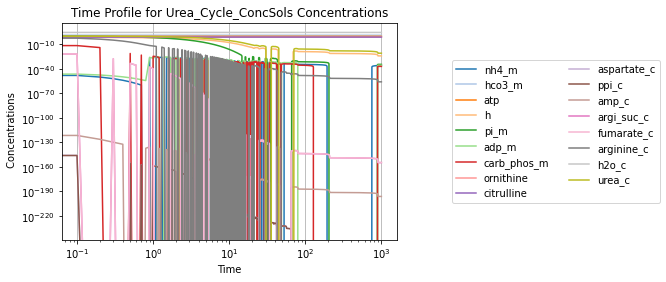

In [112]:
# Visualize the concentrations over time
conc_sol_ss, flux_sol_ss = sim.simulate(
    model, time=(t0, tf, tf*10 + 1))
conc_sol_ss.view_time_profile()

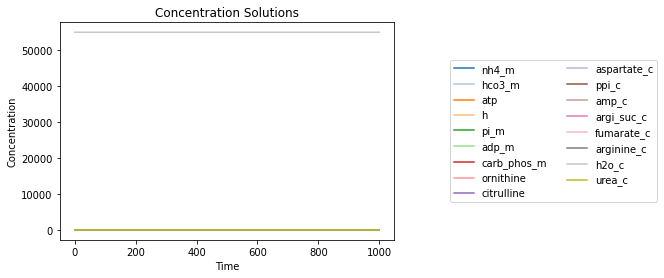

In [113]:
# Plot time profile
plot_time_profile(
    conc_sol_ss, legend="right outside",
    xlabel="Time", ylabel="Concentration",
    title=("Concentration Solutions", {"size": "large"}))

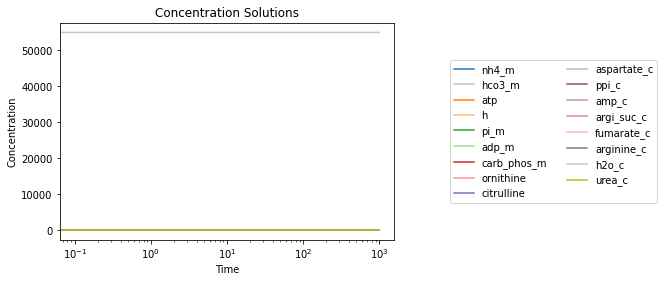

In [114]:
# Plot time profile for concentrations on log scale
plot_time_profile(
    conc_sol_ss, legend="right outside", plot_function="semilogx",
    xlabel="Time", ylabel="Concentration",
    title=("Concentration Solutions", {"size": "large"}))

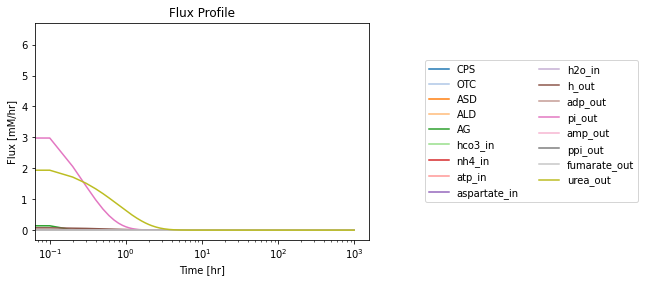

In [115]:
# Plot time profil for fluxes on log scale
plot_time_profile(
    flux_sol_ss, legend="right outside", 
    plot_function="semilogx", 
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Flux Profile", L_FONT));

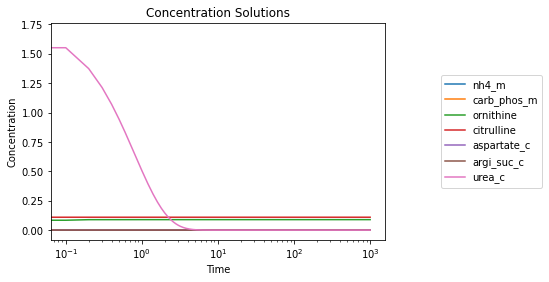

In [116]:
# Plot time profile of ammonium and urea
plot_time_profile(
    conc_sol_ss, observable=["nh4_m", "carb_phos_m", "ornithine", "citrulline", "aspartate_c", "argi_suc_c", "urea_c"], legend="right outside", plot_function="semilogx",
    xlabel="Time", ylabel="Concentration",
    title=("Concentration Solutions", {"size": "large"}))

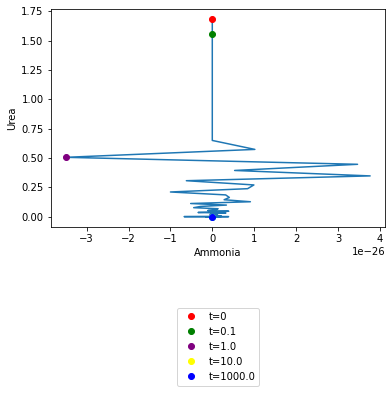

In [117]:
# Plot phase portrait of ammonium and urea
plot_phase_portrait(
    conc_sol_ss, x="nh4_m", y="urea_c", xlabel="Ammonia", ylabel="Urea",
    annotate_time_points=[t0, 1e-1, 1e0, 1e1, 1e3, tf],
    annotate_time_points_color= [
        "red", "green", "purple", "yellow", "cyan", "blue"],
    annotate_time_points_legend="lower outside")

In [118]:
# Plot tiled phase portraits of all metabolites
# plot_tiled_phase_portraits(conc_sol_ss,
#                            annotate_time_points_legend="right outside")

# Enzyme modules

## Module construction

In [119]:
CPS = EnzymeModule("CPS", name="Ammonia-dependent carbamoyl-phosphate synthase", 
                   subsystem="Urea_Cycle")

### Metabolites

In [120]:
# Add the metabolites to the EnzymeModule
CPS.add_metabolites([nh4_m, hco3_m, atp, h, pi_m, adp_m, carb_phos_m])
# Access DictList of ligands and print
print("All {0} Ligands: {1}".format(
    CPS.id, "; ".join([m.id for m in CPS.enzyme_module_ligands])))

CPS.enzyme_module_ligands_categorized =  {
    "Substrates": [nh4_m, hco3_m],
    "Cofactors": atp,
    "Products": [h, pi_m, adp_m, carb_phos_m]}

# Access DictList of ligands and print
print("All {0} ligands ({1} total):\n{2}\n".format(
    CPS.id, len(CPS.enzyme_module_ligands),
    str([m.id for m in CPS.enzyme_module_ligands])))

# Access categorized attribute for ligands and print
for group in CPS.enzyme_module_ligands_categorized:
    print("{0}: {1}".format(
        group.id, str([m.id for m in group.members])))

All CPS Ligands: nh4_m; hco3_m; atp; h; pi_m; adp_m; carb_phos_m
All CPS ligands (7 total):
['nh4_m', 'hco3_m', 'atp', 'h', 'pi_m', 'adp_m', 'carb_phos_m']

Substrates: ['nh4_m', 'hco3_m']
Cofactors: ['atp']
Products: ['h', 'pi_m', 'adp_m', 'carb_phos_m']


### Enzyme module form

In [121]:
# Make enzyme module forms per number of bound activators (Up to 4 Total)
CPS.make_enzyme_module_form(
    "cps_m", 
    name="Automatic", 
    categories=("Relaxed"),
    compartment="m");

CPS.make_enzyme_module_form(
    "cps_N_m", 
    name="Automatic", 
    categories=("Relaxed"),
    bound_metabolites={nh4_m: 1},
    compartment="m");

CPS.make_enzyme_module_form(
    "cps_NH_m", 
    name="Automatic", 
    categories=("Relaxed"),
    bound_metabolites={nh4_m: 1, hco3_m: 1},
    compartment="m");
  
CPS.make_enzyme_module_form(
    "cps_NHA_m", 
    name="Automatic", 
    categories=("Relaxed"),
    bound_metabolites={nh4_m: 1, hco3_m: 1, atp: 1, atp: 2},
    compartment="m");


# Access DictList of enzyme module forms and print
print("All {0} enzyme module forms ({1} total):\n{2}\n".format(
    CPS.id, len(CPS.enzyme_module_forms),
    str([m.id for m in CPS.enzyme_module_forms])))

# Access categorized attribute for enzyme module forms and print
for group in CPS.enzyme_module_forms_categorized:
    print("{0}: {1}\n".format(
        group.id, str(sorted([m.id for m in group.members]))))

All CPS enzyme module forms (4 total):
['cps_m', 'cps_N_m', 'cps_NH_m', 'cps_NHA_m']

Relaxed: ['cps_NHA_m', 'cps_NH_m', 'cps_N_m', 'cps_m']



## Reactions

### Create reactions

In [122]:
CPS.make_enzyme_module_reaction(
    "CPS_1".format(i), 
    name="Automatic",
    subsystem="Urea_Cycle",
    reversible=True,
    categories="nh4_m_binding",
    metabolites_to_add={
        "cps_m": -1, 
        "nh4_m": -1, 
        "cps_N_m": 1})

CPS.make_enzyme_module_reaction(
    "CPS_2", 
    name="Automatic",
    subsystem="Urea_Cycle",
    reversible=True,
    categories="hco3_m_binding",
    metabolites_to_add={
        "cps_N_m": -1, 
        "hco3_m": -1, 
        "cps_NH_m": 1})

CPS.make_enzyme_module_reaction(
    "CPS_3", 
    name="Automatic",
    subsystem="Urea_Cycle",
    reversible=True,
    categories="atp_binding",
    metabolites_to_add={
        "cps_NH_m": -1, 
        "atp": -2, 
        "cps_NHA_m": 1})

CPS.make_enzyme_module_reaction(
    "CPS_4", 
    name="Automatic",
    subsystem="Urea_Cycle",
    reversible=False,
    categories="catalyzation",
    metabolites_to_add={
        "cps_NHA_m": -1, 
        "cps_m": 1, 
        "h": 2, 
        "pi_m": 1,
        "adp_m": 2,
        "carb_phos_m": 1})

# Access DictList of enzyme module reactions and print
print("All {0} enzyme module reactions ({1} total):\n{2}\n".format(
    CPS.id, len(CPS.enzyme_module_reactions),
    str([m.name for m in CPS.enzyme_module_reactions])))

# Access categorized attribute for enzyme module reactions and print
for group in CPS.enzyme_module_reactions_categorized:
    print("{0}: {1}\n".format(
        group.id, str(sorted([m.id for m in group.members]))))

All CPS enzyme module reactions (4 total):
['cps-nh4 binding', 'cps_N-hco3 binding', 'cps_NH-atp binding', 'cps_NHA catalyzation']

nh4_m_binding: ['CPS_1']

hco3_m_binding: ['CPS_2']

atp_binding: ['CPS_3']

catalyzation: ['CPS_4']



### Unify rate parameters

In [123]:
abbreviations = ["N", "H", "A"]
ligands = [nh4_m, hco3_m, atp, pi_m, adp_m, h, carb_phos_m]

for met, unified_id in zip(ligands, abbreviations):
    category = {"N": "binding",
                "H": "binding",
                "A": "binding"
                }[unified_id]
    group = CPS.enzyme_module_reactions_categorized.get_by_id(
        "_".join((met.id, category)))
    reactions = sorted(group.members, key=attrgetter("id"))
    CPS.unify_rate_parameters(reactions, unified_id,
                              rate_type=2, enzyme_prefix=True)
            
CPS.unify_rate_parameters(
    CPS.enzyme_module_reactions_categorized.get_by_id("catalyzation").members,
    "CPS")
# Update rate laws to be in terms of kf and Keq
CPS.custom_rates.update(k2Keq(CPS.custom_rates))

# Access categorized attribute for enzyme module reactions and print
for group in CPS.enzyme_module_reactions_categorized:
    header = "Category: " + group.id
    print("\n" + header + "\n" + "-" * len(header))
    for reaction in sorted(group.members, key=attrgetter("id")):
        print(reaction.id + ": " + str(reaction.rate))


Category: nh4_m_binding
-----------------------
CPS_1: kf_CPS_N*(cps_m(t)*nh4_m(t) - cps_N_m(t)/Keq_CPS_N)

Category: hco3_m_binding
------------------------
CPS_2: kf_CPS_H*(cps_N_m(t)*hco3_m(t) - cps_NH_m(t)/Keq_CPS_H)

Category: atp_binding
---------------------
CPS_3: kf_CPS_A*(atp(t)**2*cps_NH_m(t) - cps_NHA_m(t)/Keq_CPS_A)

Category: catalyzation
----------------------
CPS_4: kf_CPS*cps_NHA_m(t)


## The steady state

In [124]:
# Make a dictionary of ODEs and lump ligands into rate parameters by giving them a value of 1
ode_dict = {}
lump_ligands = {sym.Symbol(met.id): 1 for met in CPS.enzyme_module_ligands}
for enzyme_module_form in CPS.enzyme_module_forms:
    symbol_key = sym.Symbol(enzyme_module_form.id)
    ode = sym.Eq(strip_time(enzyme_module_form.ode), 0)
    ode_dict[symbol_key] = ode.subs(lump_ligands)

rank = matrix_rank(CPS.S[7:])
print("Rank Deficiency: {0}".format(len(ode_dict) - rank))

Rank Deficiency: 1


In [125]:
reactions = CPS.enzyme_module_reactions_categorized.get_by_id(
    "catalyzation").members
CPS.make_enzyme_rate_equation(
    reactions,
    use_rates=True, update_enzyme=True)
sym.pprint(CPS.enzyme_rate_equation)

kf_CPS⋅cps_NHA_m(t)


In [126]:
# Get enzyme module forms
enzyme_module_forms = CPS.enzyme_module_forms.copy()
# Reverse list for increased performance (due to symmetry assumption)
# by solving for the most activated/inhibitors bound first.
enzyme_module_forms.reverse()

enzyme_solutions = {}
for enzyme_module_form in enzyme_module_forms:
    # Skip dependent variable
    if "cps_m" == str(enzyme_module_form):
        continue
    enzyme_module_form = sym.Symbol(enzyme_module_form.id)
    # Susbtitute in previous solutions and solve for the enzyme module form, 
    equation = ode_dict[enzyme_module_form]
    sol = sym.solveset(equation.subs(enzyme_solutions), enzyme_module_form)
    enzyme_solutions[enzyme_module_form] = list(sol)[0]
    # Update the dictionary of solutions with the solutions
    enzyme_solutions.update({
        enzyme_module_form: sol.subs(enzyme_solutions) 
        for enzyme_module_form, sol in enzyme_solutions.items()})
args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print(args)

{Keq_CPS_H, cps_m, Keq_CPS_A, kf_CPS_H, kf_CPS, kf_CPS_N, Keq_CPS_N, kf_CPS_A}


In [127]:
enzyme_rate_equation = strip_time(CPS.enzyme_rate_error(False))
print("Enzyme Net Flux Equation\n" + "-"*24)
sym.pprint(enzyme_rate_equation)

# Solve for last unknown concentration symbolically
sol = sym.solveset(enzyme_rate_equation.subs(enzyme_solutions), "cps_m")

# Update solution dictionary with the new solution
enzyme_solutions[sym.Symbol("cps_m")] = list(sol)[0]

# Update solutions with free variable solutions
enzyme_solutions = {
    enzyme_module_form: sym.simplify(solution.subs(enzyme_solutions))
    for enzyme_module_form, solution in enzyme_solutions.items()}

args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print("\n", args)

Enzyme Net Flux Equation
------------------------
-cps_NHA_m⋅kf_CPS + v_CPS

 {Keq_CPS_H, Keq_CPS_A, v_CPS, kf_CPS_H, kf_CPS, kf_CPS_N, Keq_CPS_N, kf_CPS_A}


### Numerical values

Km_NH4 = 1 (mM)

Km_HCO3 = 4

Km_ATP = 0.5

Ka_NAG = 0.14


In [128]:
numerical_values = {}

# Get ligand IDs and parameter IDs
ligand_ids = sorted([str(ligand) for ligand in CPS.enzyme_module_ligands])
parameter_ids = ["_".join((CPS.id, abbrev)) for abbrev in abbreviations + ["L"]]
print("Ligand IDs: " + str(ligand_ids))
print("Parameter IDs: " + str(parameter_ids))

# Get the steady state flux value and add to numerical values
CPS.enzyme_rate = model.reactions.get_by_id(CPS.id).steady_state_flux
numerical_values.update({CPS.enzyme_flux_symbol_str: CPS.enzyme_rate})

# Get the steady state concentration values and add to numerical values
initial_conditions = {
    str(ligand): model.initial_conditions[model.metabolites.get_by_id(ligand)]
    for ligand in ligand_ids}

# Define parameter values and add to numerical values
# Because of the QEA, invert dissociation constants for Keq
parameter_values = {
    "Keq_" + parameter_id: value 
    for parameter_id, value in zip(parameter_ids, [1/1, 1/4, 1/0.5, 0.0011])}

# Display numerical values
print("\nNumerical Values\n----------------")
for k, v in numerical_values.items():
    print("{0} = {1}".format(k, v))

Ligand IDs: ['adp_m', 'atp', 'carb_phos_m', 'h', 'hco3_m', 'nh4_m', 'pi_m']
Parameter IDs: ['CPS_N', 'CPS_H', 'CPS_A', 'CPS_L']

Numerical Values
----------------
v_CPS = 5.391893031357447e-45


In [129]:
# Match abbreviations to their corresponding ligands
abbreviation_dict = {"CPS_N": "nh4_m", "CPS_H": "hco3_m", "CPS_A": "atp", "CPS_L": ""}

k2K = {sym.Symbol("kr_" + p): sym.Symbol("kf_" + p)*sym.Symbol("K_" + p) for p in abbreviation_dict.keys()}
enzyme_solutions = {met: sym.simplify(Keq2k(solution).subs(enzyme_solutions).subs(k2K))
                    for met, solution in enzyme_solutions.items()}
K_values = dict(zip(["K_" + p for p in abbreviation_dict], [1, 4, 0.5, 0.0011]))

for abbrev, ligand_id in abbreviation_dict.items():
    K_str = "K_" + abbrev
    if ligand_id:
        numerical_value = K_values[K_str]/initial_conditions[ligand_id]
    else:
        numerical_value = 1/K_values[K_str]
    numerical_values[sym.Symbol(K_str)] = numerical_value
    
enzyme_solutions = {met: sym.simplify(solution.subs(numerical_values))
                    for met, solution in enzyme_solutions.items()}

# Display numerical values
print("\nNumerical Values\n----------------")
for k, v in numerical_values.items():
    print("{0} = {1}".format(k, v))


Numerical Values
----------------
v_CPS = 5.391893031357447e-45
K_CPS_N = 8.439842309188784e+45
K_CPS_H = 0.1635222696891032
K_CPS_A = 0.507872016251904
K_CPS_L = 909.090909090909


In [130]:
# Substitute values into equations
enzyme_solutions = {
    enzyme_module_form: sym.simplify(solution.subs(numerical_values))
    for enzyme_module_form, solution in enzyme_solutions.items()}

args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print(args)

{kf_CPS_N, kf_CPS_A, kf_CPS_H, kf_CPS}


### Determine rate constants

In [131]:
sym.pprint(CPS.enzyme_concentration_total_equation)

cps_NHA_m(t) + cps_NH_m(t) + cps_N_m(t) + cpsₘ(t)


In [132]:
CPS.enzyme_concentration_total = 40
print(CPS.enzyme_concentration_total)

40


In [133]:
enzyme_total_constraint = abs(strip_time(CPS.enzyme_concentration_total_error(use_values=False)))
sym.pprint(enzyme_total_constraint)

│-CPS_Total + cps_NHA_m + cps_NH_m + cps_N_m + cpsₘ│


In [134]:
# Substitute value for enzyme concentration total
enzyme_total_constraint = enzyme_total_constraint.subs({CPS.enzyme_total_symbol_str: CPS.enzyme_concentration_total})
# Substitute solutions into constraint and simplify
enzyme_total_constraint = sym.simplify(enzyme_total_constraint.subs(enzyme_solutions))
sym.pprint(enzyme_total_constraint)

│      5.39189303135745e-45   45.5067269326707   7.44136327415256   3.77926016
│-40 + ──────────────────── + ──────────────── + ──────────────── + ──────────
│            kf_CPS_N             kf_CPS_H           kf_CPS_A            kf_CP

970673│
──────│
S     │


In [135]:
# Create a sorted tuple of the arguments to ensure the input format does not change
args = tuple(sorted([str(arg) for arg in list(args)]))
# Create the objective function as a lambda function
objective_function = lambda x: sym.lambdify(args, enzyme_total_constraint)(*x)

In [136]:
# Set the values for the constraint bounds
r_T_lb, r_T_ub = (0.01, 0.015)
# Make a symbolic expression for enzyme fraction.
r_T_expr = CPS.make_enzyme_fraction(
    categorized_attr="forms", top="Relaxed", bottom="Equation",
    use_values=False)
# Substitute solutions into the expression to make
# solely dependent on the rate constants
r_T_expr = sym.simplify(strip_time(r_T_expr).subs(enzyme_solutions))

# Make lambda functions for the T fraction constraint
r_T_lb_constraint = lambda x: sym.lambdify(args, r_T_expr - r_T_lb)(*x)
r_T_ub_constraint = lambda x: sym.lambdify(args, r_T_ub - r_T_expr)(*x)

In [137]:
print("Ordered Args: {0}\n".format(str(args)))
# Set arguments for minimization
kf_bounds = ((1e2, 1e8), (1e2, 1e8), (1e2, 1e8), (1e2, 1e8))
initial_guess = [
    3.07e5,
    2e5,
    1e6,
    2e6]

# Find a feasible solution
sol = optimize.minimize(
    objective_function, x0=initial_guess,
    method="trust-constr",
    bounds=kf_bounds,
    options={"gtol": 1e-20, "xtol": 1e-20, "maxiter": 1e4, "disp": True})

# Check whether optimzation was successful
print("\nOptimization Success: {0}".format(sol.success))
if sol.success:
    # Update the paramter values dictionary with the feasible solution
    parameter_values.update(dict(zip(args, [round(x) for x in sol.x])))
    print("Optimization Optimality: {0:.4e}".format(sol.optimality))
    print("Parameter Solutions: {:}".format(str({arg: parameter_values[arg] for arg in args})))
    # Plug solutions back into constraints for validation
    print("Optimization Error: {0:.4e}".format(enzyme_total_constraint.subs(parameter_values)))

Ordered Args: ('kf_CPS', 'kf_CPS_A', 'kf_CPS_H', 'kf_CPS_N')



/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187 UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187 UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187 UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187 UserWarning: delt

`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 40, CG iterations: 57, optimality: 1.86e-10, constraint violation: 0.00e+00, execution time: 0.32 s.

Optimization Success: True
Optimization Optimality: 1.8597e-10
Parameter Solutions: {'kf_CPS': 307000, 'kf_CPS_A': 200000, 'kf_CPS_H': 1000000, 'kf_CPS_N': 2000000}
Optimization Error: 4.0000e+1


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187 UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187 UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.


In [138]:
# Display numerical values
for k, v in parameter_values.items():
    print("{0} = {1}".format(k, v))

Keq_CPS_N = 1.0
Keq_CPS_H = 0.25
Keq_CPS_A = 2.0
Keq_CPS_L = 0.0011
kf_CPS = 307000
kf_CPS_A = 200000
kf_CPS_H = 1000000
kf_CPS_N = 2000000


### Solve steady state concentrations numerically

In [139]:
# Substitute values into equations
initial_conditions.update({
    str(enzyme_module_form): float(sym.simplify(solution.subs(parameter_values)))
    for enzyme_module_form, solution in enzyme_solutions.items()})

for header, dictlist in zip(["Ligand", "\nEnzyme"], [CPS.enzyme_module_ligands, CPS.enzyme_module_forms]):
    header += " Concentrations"
    print("\n".join([header, "-" * len(header)]))
    for form in dictlist:
        ic = initial_conditions[form.id]
        print("{0} = {1}".format(form.id, ic))

Ligand Concentrations
---------------------
nh4_m = 1.1848562607754664e-46
hco3_m = 24.461500000000015
atp = 0.9845000000000009
h = 7.484530419439464e-37
pi_m = 1.137
adp_m = 2.5970328464212366e-46
carb_phos_m = 0.029

Enzyme Concentrations
----------------------
cps_m = 9.502383701583333e-05
cps_N_m = 1.1258958821111763e-50
cps_NH_m = 3.587930745401882e-50
cps_NHA_m = 1.7563169483249012e-50


In [140]:
# Set initial conditions
for met, concentration in initial_conditions.items():
    CPS.metabolites.get_by_id(str(met)).ic = concentration

# Add the custom parameters and values for kf and Keq to model
CPS.custom_parameters.update(parameter_values)
# CPS_L = CPS.enzyme_module_reactions.CPS_L
# CPS_L.kf = CPS.custom_parameters.pop(CPS_L.kf_str)
# CPS_L.Keq = CPS.custom_parameters.pop(CPS_L.Keq_str)

# Set parameter values in reaction fields
for group in CPS.enzyme_module_reactions_categorized:
    if group.id == "nh4_m_binding":
        param_id = "CPS_N"
    elif group.id == "hco3_m_binding":
        param_id = "CPS_H"
    elif group.id == "atp_binding":
        param_id = "CPS_A"
    elif group.id == "catalyzation":
        param_id = "CPS"
    else:
        continue
    for reaction in group.members:
        kf, Keq = ("kf_" + param_id, "Keq_" + param_id)
        if kf in CPS.custom_parameters:
            reaction.kf = CPS.custom_parameters[kf]
        if Keq in CPS.custom_parameters:
            reaction.Keq = CPS.custom_parameters[Keq]

In [141]:
CPS.update_S(array_type="DataFrame", dtype=int)

,CPS_1,CPS_2,CPS_3,CPS_4
nh4_m,-1,0,0,0
hco3_m,0,-1,0,0
atp,0,0,-2,0
h,0,0,0,2
pi_m,0,0,0,1
adp_m,0,0,0,2
carb_phos_m,0,0,0,1
cps_m,-1,0,0,1
cps_N_m,1,-1,0,0
cps_NH_m,0,1,-1,0


## Module validation

In [142]:
qcqa_model(CPS, parameters=True, concentrations=True, 
           fluxes=False, superfluous=True, elemental=True)

╒══════════════════════════════════════════════╕
│ MODEL ID: CPS                                │
│ SIMULATABLE: True                            │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ============================================ │
│ Elemental                                    │
│ ------------------------------               │
│ CPS_4: {charge: -1.0; H: -1.0}               │
│ ============================================ │
╘══════════════════════════════════════════════╛


### Constraint satisfaction and error values

In [143]:
t_fraction = CPS.make_enzyme_fraction("forms", top="Relaxed",
                                      bottom="Equation", use_values=True)
print("Enzyme T-fraction: {:.4f}".format(t_fraction))

print("Concentration Absolute Error: {0:.4e}".format(
    abs(CPS.enzyme_concentration_total_error(use_values=True))))
print("Flux Absolute Error: {0:.4e}".format(
    abs(CPS.enzyme_rate_error(use_values=True))))

Enzyme T-fraction: 1.0000
Concentration Absolute Error: 4.0000e+01
Flux Absolute Error: 0.0000e+00


### Add enzyme module to mass model

In [144]:
# Load and merge main model with CPS module
# Remove the CPS MassReaction, then merge the EnzymeModule into the MassModel
model.remove_reactions([model.reactions.get_by_id("CPS")])
model_CPS = model.merge(CPS)
model_CPS

Name,Urea_Cycle
Memory address,0x07f01765facd0
Stoichiometric Matrix,21x20
Matrix Rank,19
Number of metabolites,21
Initial conditions defined,21/21
Number of reactions,20
Number of genes,0
Number of enzyme modules,1
Number of groups,8
Objective expression,0


In [145]:
print(str(model_CPS.enzyme_modules) + "\n")
print("Attribute Accessors:\n-------------------\n" + "\n".join(list(
    model_CPS.enzyme_modules.CPS.keys())) + "\n")
model_CPS.enzyme_modules.CPS

[<EnzymeModuleDict CPS at 0x7f0173305200>]

Attribute Accessors:
-------------------
id
name
subsystem
enzyme_module_ligands
enzyme_module_forms
enzyme_module_reactions
enzyme_module_ligands_categorized
enzyme_module_forms_categorized
enzyme_module_reactions_categorized
enzyme_concentration_total
enzyme_rate
enzyme_concentration_total_equation
enzyme_rate_equation
S
model



Name,CPS
Memory address,0x07f0173305200
Stoichiometric Matrix,11x4
Matrix Rank,4
Subsystem,Urea_Cycle
Number of Ligands,7
Number of EnzymeForms,4
Number of EnzymeModuleReactions,4
Enzyme Concentration Total,40
Enzyme Net Flux,5.391893031357447e-45


### Validate steady state

Successfully loaded MassModel 'Urea_Cycle' into RoadRunner.
Setting output selections
Setting simulation values for 'Urea_Cycle'
Setting output selections
Getting time points
Simulating 'Urea_Cycle'
Found steady state for 'Urea_Cycle'.
Updating 'Urea_Cycle' values
Adding 'Urea_Cycle' simulation solutions to output


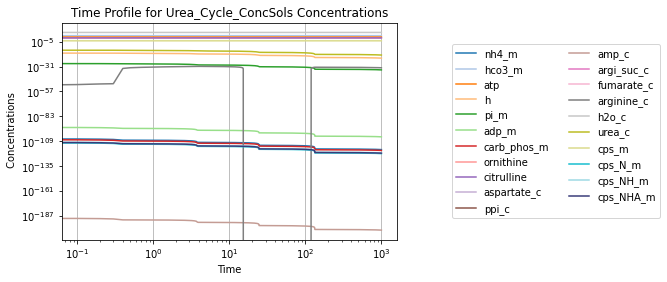

In [146]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(model_CPS, verbose=True)
sim.find_steady_state(model_CPS, strategy="simulate",
                      update_values=True, verbose=True,
                      tfinal=1e4, steps=1e6)

# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(
    model_CPS,time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

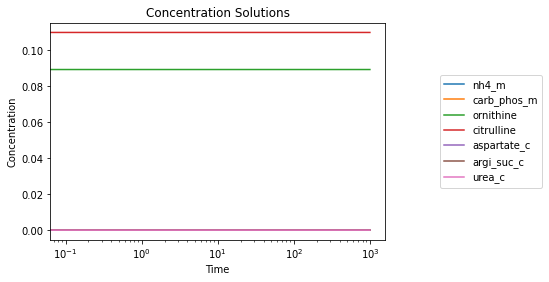

In [147]:
# Plot time profile of ammonium and urea
plot_time_profile(
    conc_sol, observable=["nh4_m", "carb_phos_m", "ornithine", "citrulline", "aspartate_c", "argi_suc_c", "urea_c"], legend="right outside", plot_function="semilogx",
    xlabel="Time", ylabel="Concentration",
    title=("Concentration Solutions", {"size": "large"}))

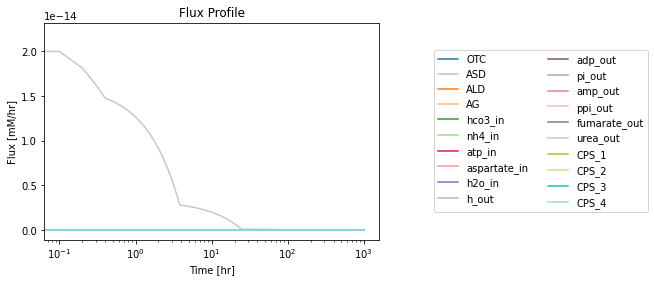

In [148]:
# Plot time profil for fluxes on log scale
plot_time_profile(
    flux_sol, legend="right outside", 
    plot_function="semilogx", 
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Flux Profile", L_FONT));